In [2]:
import pandas as pd
import numpy as np
from pandas.core.common import random_state
from pandas.core.interchange.from_dataframe import categorical_column_to_series
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tensorflow.python.ops.gen_dataset_ops import model_dataset
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [9]:
chunk_size = 100000

In [8]:
# Initialize variables for analysis
total_rows = 0
column_sums = None
column_squared_sums = None

In [6]:
# Step 3: Read the data in chunks
def read_csv_in_chunks(file_path, chunk_size):
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        yield chunk

In [4]:
# Step 4: Sample 20% of observation
labels = pd.read_csv('data/train_labels.csv')
sample_labels = labels.sample(frac=0.2, random_state=42)

In [10]:
# Read data
sampled_data = []
for chunk in read_csv_in_chunks('data/train_data.csv', chunk_size):
    merged_chunk = pd.merge(chunk, sample_labels, on='customer_ID', how='inner')
    sampled_data.append(merged_chunk)
    
# Combine all chunks into a single dataframe
development_sample = pd.concat(sampled_data, ignore_index=True)

# Save the development sample
development_sample.to_csv('data/development_sample.csv', index=False)

In [8]:
# load development_sample
data = []
for chunk in read_csv_in_chunks('data/development_sample.csv', chunk_size):
    data.append(chunk)

    

In [9]:
df = pd.concat(data, ignore_index=True)
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,NaN,NaN,0.008263,0.006609,0.007370,NaN,0.007171,0.005120,0.007513,0
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,NaN,NaN,0.001986,0.004050,0.000796,NaN,0.001802,0.002364,0.003987,0
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,NaN,NaN,0.009515,0.008757,0.009219,NaN,0.003134,0.001686,0.001265,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,NaN,NaN,0.002524,0.007841,0.007421,NaN,0.000728,0.003591,0.007998,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,NaN,NaN,0.003823,0.009599,0.006957,NaN,0.008746,0.007101,0.006658,0


In [10]:
def calculate_default_rate(data):
    # Initialize a DataFrame to store the results
    default_rates = pd.DataFrame(columns=["Category", "#Observations", "Default rate"])
    
    # Get the total number of unique customer IDs
    total_customers = len(data["customer_ID"].unique())
    
    # Calculate default rate for all applicants
    default_rate_all = data["target"].mean()
    default_rates.loc[0] = ["All applicants", total_customers, default_rate_all]
    
    # Calculate default rate for each category of historic data length
    for months in range(13, 0, -1):  # Iterate from 13 months to 1 month
        category_customers = data.groupby("customer_ID").size() == months  # Check if each customer has data for the specific number of months
        category_observations = category_customers.sum()  # Get the number of customers in this category
        category_data = data[data["customer_ID"].isin(category_customers[category_customers].index)]  # Filter data for the specific category
        default_rate_category = category_data["target"].mean()  # Calculate default rate for this category
        default_rates.loc[len(default_rates)] = [f"Applications with {months} months of historic data", category_observations, default_rate_category]
    
    return default_rates

# Call the function with your development_sample dataset
default_rates_data = calculate_default_rate(development_sample)

# Display the results
print(default_rates_data)

                                        Category  #Observations  Default rate
0                                 All applicants          91783      0.246498
1   Applications with 13 months of historic data          77348      0.229405
2   Applications with 12 months of historic data           2115      0.378723
3   Applications with 11 months of historic data           1159      0.440897
4   Applications with 10 months of historic data           1329      0.465764
5    Applications with 9 months of historic data           1278      0.435837
6    Applications with 8 months of historic data           1169      0.450813
7    Applications with 7 months of historic data           1046      0.414914
8    Applications with 6 months of historic data           1109      0.412985
9    Applications with 5 months of historic data            933      0.394427
10   Applications with 4 months of historic data            938      0.430704
11   Applications with 3 months of historic data           1158 

In [11]:
categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [12]:
# Step 5: One-hot encoding for categorical variables
# List of known categorical columns
# List of categorical columns

# Function to read and process data in chunks
def process_chunks(file_path, chunk_size=100000):
    encoded_chunks = []
    
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Convert all specified columns to strings
        for col in categorical_columns:
            chunk[col] = chunk[col].astype(str)
        
        # Perform one-hot encoding
        encoded_chunk = pd.get_dummies(chunk, columns=categorical_columns)
        
        # Ensure the encoded columns are of type int (0 or 1)
        for col in encoded_chunk.columns:
            if col.startswith(tuple(categorical_columns)):
                encoded_chunk[col] = encoded_chunk[col].astype(int)
        
        encoded_chunks.append(encoded_chunk)
        
        print(f"Processed chunk of size {len(chunk)}")
    
    return pd.concat(encoded_chunks, ignore_index=True)

# Process the file
df_encoded = process_chunks('data/development_sample.csv')

print("One-hot encoding completed.")
print(f"Shape of encoded DataFrame: {df_encoded.shape}")

# Display the first few rows of the encoded DataFrame
print(df_encoded.head())

# Check the data types of the encoded columns
print(df_encoded.dtypes)

Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 100000
Processed chunk of size 7082
One-hot encoding completed.
Shape of encoded DataFrame: (1107082, 235)
                                         customer_ID         S_2       P_2  \
0  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-03-11  0.374606   
1  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-04-22  0.414269   
2  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-05-12  0.413310   
3  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-06-10  0.328983   
4  000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...  2017-07-19  0.496989   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.03351

In [13]:
df_encoded.to_csv('data/train_encoded_data.csv', index=False)

***USE THE BELOW CODE FOR QUESTION 6~***

In [14]:
# Step 6: Feature Engineering
df = pd.read_csv('data/train_encoded_data.csv')


In [15]:
target_df = df[['customer_ID', 'target']].drop_duplicates()

In [16]:
target_df['target'].unique()

array([0, 1])

In [17]:
df['S_2'] = pd.to_datetime(df['S_2'])
df = df.drop(columns=['target'])
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_66_1.0,D_66_nan,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,0,1,0,0,0,0,0,0,0,1
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,0,1,0,0,0,0,0,0,0,1
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,0,1,0,0,1,0,0,0,0,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,0,1,0,0,1,0,0,0,0,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,0,1,0,0,1,0,0,0,0,0


In [18]:
# Numerical Columns:
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

In [19]:
df[numerical_columns].head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_66_1.0,D_66_nan,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,0.152932,NaN,...,0,1,0,0,0,0,0,0,0,1
1,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,0.154147,0.053474,...,0,1,0,0,0,0,0,0,0,1
2,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,0.150513,0.035667,...,0,1,0,0,1,0,0,0,0,0
3,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,0.148605,0.166655,...,0,1,0,0,1,0,0,0,0,0
4,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,0.147616,0.117810,...,0,1,0,0,1,0,0,0,0,0


In [20]:
# Aggregation For all the numerical columns

def calculate_numerical_statistics(df, time_period):
    last_date = df['S_2'].max()
    time_period_ago = last_date - pd.DateOffset(months=time_period)

    data_last_time_period = df[(df['S_2'] > time_period_ago) & (df['S_2'] <= last_date)]

    average_spend_last_time_period = data_last_time_period.groupby('customer_ID')[numerical_columns].agg(['mean', 'min', 'max', 'sum'])
    average_spend_last_time_period.columns = [f'{col}_{agg}_{time_period}' for col, agg in average_spend_last_time_period.columns]

    return average_spend_last_time_period


# Calculate statistics for different time periods
average_spend_3_months = calculate_numerical_statistics(df, 3)
average_spend_6_months = calculate_numerical_statistics(df, 6)
average_spend_9_months = calculate_numerical_statistics(df, 9)
average_spend_12_months = calculate_numerical_statistics(df, 12)

feature_engineered_df = pd.merge(average_spend_3_months, average_spend_6_months, on='customer_ID', how='inner')
feature_engineered_df = pd.merge(feature_engineered_df, average_spend_9_months, on='customer_ID', how='inner')
feature_engineered_df = pd.merge(feature_engineered_df, average_spend_12_months, on='customer_ID', how='inner')

feature_engineered_df.head()


/var/folders/jm/4lz5rdmd4gn8qjywng68z9d00000gn/T/ipykernel_40152/3144716453.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_engineered_df = pd.merge(average_spend_3_months, average_spend_6_months, on='customer_ID', how='inner')
/var/folders/jm/4lz5rdmd4gn8qjywng68z9d00000gn/T/ipykernel_40152/3144716453.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_engineered_df = pd.merge(feature_engineered_df, average_spend_9_months, on='customer_ID', how='inner')
/var/folders/jm/4lz5rdmd4gn8qjywng68z9d00000gn/T/ipyk

,P_2_mean_3,P_2_min_3,P_2_max_3,P_2_sum_3,D_39_mean_3,D_39_min_3,D_39_max_3,D_39_sum_3,B_1_mean_3,B_1_min_3,...,D_68_5.0_max_12,D_68_5.0_sum_12,D_68_6.0_mean_12,D_68_6.0_min_12,D_68_6.0_max_12,D_68_6.0_sum_12,D_68_nan_mean_12,D_68_nan_min_12,D_68_nan_max_12,D_68_nan_sum_12
customer_ID,,,,,,,,,,,,,,,,,,,,,
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4,0.447801,0.414444,0.477116,1.343404,0.014288,0.000467,0.035885,0.042865,0.069795,0.009413,...,0,0,0.000000,0,0,0,0.083333,0,1,1
000445609ff2a39d2dd02484899affa5696210a95f6869f26390bd26eeb3b651,0.976846,0.974383,0.978897,2.930539,0.002024,0.001221,0.002629,0.006072,0.008831,0.006584,...,0,0,1.000000,1,1,12,0.000000,0,0,0
0004837f0c785928a29a6f83f70f4a1c54caec483a773ff4b5b317ac251abda0,0.638958,0.634894,0.642295,1.916874,0.574667,0.415254,0.685210,1.724002,0.431032,0.429032,...,1,12,0.000000,0,0,0,0.000000,0,0,0
0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704029f989240c733b6d0,0.973429,0.963991,0.980221,2.920287,0.268469,0.009431,0.470704,0.805407,0.023506,0.019392,...,1,7,0.416667,0,1,5,0.000000,0,0,0
00050d84c6d26e26cd2b18c3eed83d3130c270e2361470ff272f9409103d067f,0.993352,0.968914,1.006598,2.980056,0.092158,0.005624,0.150871,0.276473,0.040335,0.026597,...,0,0,1.000000,1,1,12,0.000000,0,0,0


In [21]:
feature_engineered_df.to_csv('data/feature_engineered_data.csv')

In [22]:
# Categorical Columns:
one_hot_encoded_col = []
for ftr in df.columns:
    for column in categorical_columns:
        if ftr.startswith(column):
            one_hot_encoded_col.append(ftr)

In [23]:
# feature engineering for categorical values 
def calculate_categorical_statistics(df, time_period, one_hot_encoded_cols):
    # Get the last date in the dataset
    last_date = df['S_2'].max()
    
    # Calculate the date for the start of the time period
    time_period_start = last_date - pd.DateOffset(months=time_period)
    
    # Filter the data for the specified time period
    data_last_time_period = df[(df['S_2'] > time_period_start) & (df['S_2'] <= last_date)]
    
    # Calculate the positive response rates for each customer
    positive_response_rates = data_last_time_period.groupby('customer_ID')[one_hot_encoded_cols].mean()
    positive_response_rates.columns = [f'{col}_response_rate_{time_period}' for col in positive_response_rates.columns]
    
    # Calculate whether each customer ever responded positively
    ever_responded = data_last_time_period.groupby('customer_ID')[one_hot_encoded_cols].any().astype(int)
    ever_responded.columns = [f'{col}_ever_respond_{time_period}' for col in ever_responded.columns]
    
    # Merge the two DataFrames on 'customer_ID'
    merged_df = pd.merge(positive_response_rates, ever_responded, on='customer_ID', how='inner')
    
    return merged_df

cat_stats_3_months = calculate_categorical_statistics(df, 3, one_hot_encoded_col)
cat_stats_6_months = calculate_categorical_statistics(df, 6, one_hot_encoded_col)
cat_stats_9_months = calculate_categorical_statistics(df, 9, one_hot_encoded_col)
cat_stats_12_months = calculate_categorical_statistics(df, 12, one_hot_encoded_col)

final_categorical_df = pd.merge(cat_stats_3_months, cat_stats_6_months, on='customer_ID', how='inner')
final_categorical_df = pd.merge(final_categorical_df, cat_stats_9_months, on='customer_ID', how='inner')
final_feature_engineered_df = pd.merge(final_categorical_df, cat_stats_12_months, on='customer_ID', how='inner')

final_feature_engineered_df.head()

,B_30_0.0_response_rate_3,B_30_1.0_response_rate_3,B_30_2.0_response_rate_3,B_30_nan_response_rate_3,B_38_1.0_response_rate_3,B_38_2.0_response_rate_3,B_38_3.0_response_rate_3,B_38_4.0_response_rate_3,B_38_5.0_response_rate_3,B_38_6.0_response_rate_3,...,D_66_1.0_ever_respond_12,D_66_nan_ever_respond_12,D_68_0.0_ever_respond_12,D_68_1.0_ever_respond_12,D_68_2.0_ever_respond_12,D_68_3.0_ever_respond_12,D_68_4.0_ever_respond_12,D_68_5.0_ever_respond_12,D_68_6.0_ever_respond_12,D_68_nan_ever_respond_12
customer_ID,,,,,,,,,,,,,,,,,,,,,
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4,0.666667,0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.666667,0.0,...,0,1,0,0,1,1,0,0,0,1
000445609ff2a39d2dd02484899affa5696210a95f6869f26390bd26eeb3b651,1.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0
0004837f0c785928a29a6f83f70f4a1c54caec483a773ff4b5b317ac251abda0,0.666667,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,1,0,0
0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704029f989240c733b6d0,1.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,1,1,0
00050d84c6d26e26cd2b18c3eed83d3130c270e2361470ff272f9409103d067f,1.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,...,0,1,0,0,0,0,0,0,1,0


In [24]:
# Integrate feature engineered data
feature_engineered_df = pd.merge(feature_engineered_df, final_feature_engineered_df, on='customer_ID', how='inner')
feature_engineered_df.head()

/var/folders/jm/4lz5rdmd4gn8qjywng68z9d00000gn/T/ipykernel_40152/1743165620.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_engineered_df = pd.merge(feature_engineered_df, final_feature_engineered_df, on='customer_ID', how='inner')


,P_2_mean_3,P_2_min_3,P_2_max_3,P_2_sum_3,D_39_mean_3,D_39_min_3,D_39_max_3,D_39_sum_3,B_1_mean_3,B_1_min_3,...,D_66_1.0_ever_respond_12,D_66_nan_ever_respond_12,D_68_0.0_ever_respond_12,D_68_1.0_ever_respond_12,D_68_2.0_ever_respond_12,D_68_3.0_ever_respond_12,D_68_4.0_ever_respond_12,D_68_5.0_ever_respond_12,D_68_6.0_ever_respond_12,D_68_nan_ever_respond_12
customer_ID,,,,,,,,,,,,,,,,,,,,,
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4,0.447801,0.414444,0.477116,1.343404,0.014288,0.000467,0.035885,0.042865,0.069795,0.009413,...,0,1,0,0,1,1,0,0,0,1
000445609ff2a39d2dd02484899affa5696210a95f6869f26390bd26eeb3b651,0.976846,0.974383,0.978897,2.930539,0.002024,0.001221,0.002629,0.006072,0.008831,0.006584,...,0,1,0,0,0,0,0,0,1,0
0004837f0c785928a29a6f83f70f4a1c54caec483a773ff4b5b317ac251abda0,0.638958,0.634894,0.642295,1.916874,0.574667,0.415254,0.685210,1.724002,0.431032,0.429032,...,0,1,0,0,0,0,0,1,0,0
0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704029f989240c733b6d0,0.973429,0.963991,0.980221,2.920287,0.268469,0.009431,0.470704,0.805407,0.023506,0.019392,...,0,1,0,0,0,0,0,1,1,0
00050d84c6d26e26cd2b18c3eed83d3130c270e2361470ff272f9409103d067f,0.993352,0.968914,1.006598,2.980056,0.092158,0.005624,0.150871,0.276473,0.040335,0.026597,...,0,1,0,0,0,0,0,0,1,0


In [25]:
feature_engineered_df = pd.read_csv('data/feature_engineered_data.csv')

In [26]:
feature_engineered_df.head()

,customer_ID,P_2_mean_3,P_2_min_3,P_2_max_3,P_2_sum_3,D_39_mean_3,D_39_min_3,D_39_max_3,D_39_sum_3,B_1_mean_3,...,D_68_5.0_max_12,D_68_5.0_sum_12,D_68_6.0_mean_12,D_68_6.0_min_12,D_68_6.0_max_12,D_68_6.0_sum_12,D_68_nan_mean_12,D_68_nan_min_12,D_68_nan_max_12,D_68_nan_sum_12
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.447801,0.414444,0.477116,1.343404,0.014288,0.000467,0.035885,0.042865,0.069795,...,0,0,0.000000,0,0,0,0.083333,0,1,1
1,000445609ff2a39d2dd02484899affa5696210a95f6869...,0.976846,0.974383,0.978897,2.930539,0.002024,0.001221,0.002629,0.006072,0.008831,...,0,0,1.000000,1,1,12,0.000000,0,0,0
2,0004837f0c785928a29a6f83f70f4a1c54caec483a773f...,0.638958,0.634894,0.642295,1.916874,0.574667,0.415254,0.685210,1.724002,0.431032,...,1,12,0.000000,0,0,0,0.000000,0,0,0
3,0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704...,0.973429,0.963991,0.980221,2.920287,0.268469,0.009431,0.470704,0.805407,0.023506,...,1,7,0.416667,0,1,5,0.000000,0,0,0
4,00050d84c6d26e26cd2b18c3eed83d3130c270e2361470...,0.993352,0.968914,1.006598,2.980056,0.092158,0.005624,0.150871,0.276473,0.040335,...,0,0,1.000000,1,1,12,0.000000,0,0,0


In [27]:
feature_engineered_df = pd.merge(feature_engineered_df, target_df, on='customer_ID', how='inner')
feature_engineered_df.head()

,customer_ID,P_2_mean_3,P_2_min_3,P_2_max_3,P_2_sum_3,D_39_mean_3,D_39_min_3,D_39_max_3,D_39_sum_3,B_1_mean_3,...,D_68_5.0_sum_12,D_68_6.0_mean_12,D_68_6.0_min_12,D_68_6.0_max_12,D_68_6.0_sum_12,D_68_nan_mean_12,D_68_nan_min_12,D_68_nan_max_12,D_68_nan_sum_12,target
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.447801,0.414444,0.477116,1.343404,0.014288,0.000467,0.035885,0.042865,0.069795,...,0,0.000000,0,0,0,0.083333,0,1,1,0
1,000445609ff2a39d2dd02484899affa5696210a95f6869...,0.976846,0.974383,0.978897,2.930539,0.002024,0.001221,0.002629,0.006072,0.008831,...,0,1.000000,1,1,12,0.000000,0,0,0,0
2,0004837f0c785928a29a6f83f70f4a1c54caec483a773f...,0.638958,0.634894,0.642295,1.916874,0.574667,0.415254,0.685210,1.724002,0.431032,...,12,0.000000,0,0,0,0.000000,0,0,0,0
3,0004ec03ca1ab2adb9aa260c61ba5dce8185e19d3ab704...,0.973429,0.963991,0.980221,2.920287,0.268469,0.009431,0.470704,0.805407,0.023506,...,7,0.416667,0,1,5,0.000000,0,0,0,0
4,00050d84c6d26e26cd2b18c3eed83d3130c270e2361470...,0.993352,0.968914,1.006598,2.980056,0.092158,0.005624,0.150871,0.276473,0.040335,...,0,1.000000,1,1,12,0.000000,0,0,0,0


In [ ]:
feature_engineered_df.to_csv('data/feature_engineered_data.csv')

***USE THE BELOW CODE FOR QUESTION 7~***

In [11]:
df = pd.read_csv('data/feature_engineered_data.csv')

In [12]:
# Step 7; Train-test split
# Use a random seed of 42 for the split.
# Split the data into features and target
X = df.drop(columns=['customer_ID', 'target'])
y = df['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



In [59]:
# save train and test data as csv
X_train.to_csv('data/X_train.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
X_test1.to_csv('data/X_test1.csv', index=False)
y_test1.to_csv('data/y_test1.csv', index=False)
X_test2.to_csv('data/X_test2.csv', index=False)
y_test2.to_csv('data/y_test2.csv', index=False)

In [13]:
# Step 8: Calculate feature importance using XGBoost

# Load the training data
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier()

# Fit the model
xgb_model.fit(X_train, y_train)

# # Plot the feature importance
# plot_importance(xgb_model)

# Save the feature importance
feature_importance = xgb_model.feature_importances_
np.save('feature_importance.npy', feature_importance)

# Display the feature importance
print("Feature importance:")
print(feature_importance)

Feature importance:
[0.00024673 0.1788193  0.0194177  ... 0.         0.         0.        ]


In [23]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [24]:
feature_importance_df.to_csv('data/feature_importance.csv', index=False)

In [25]:
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.005]
important_features

,Feature,Importance
1,P_2_mean_3,0.178819
2,P_2_min_3,0.019418
17,R_1_mean_3,0.018642
10,B_1_min_3,0.017141
9,B_1_mean_3,0.011456
14,B_2_min_3,0.008486
99,B_9_max_3,0.005448
16,B_2_sum_3,0.005181


In [27]:
# Apply only importamt features
# Run default XBG
X_train_important = X_train[important_features['Feature']]

xgb_model.fit(X_train_important, y_train)

feature_importance_important = xgb_model.feature_importances_

feature_importance_important_df = pd.DataFrame({
    'Feature': X_train_important.columns,
    'Importance': feature_importance_important
})
feature_importance_important_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_important_df


,Feature,Importance
1,P_2_mean_3,0.178819
2,P_2_min_3,0.019418
17,R_1_mean_3,0.018642
10,B_1_min_3,0.017141
9,B_1_mean_3,0.011456
...,...,...
915,D_68_4.0_max_3,0.000000
2629,D_116_1.0_mean_9,0.000000
1856,D_68_nan_sum_6,0.000000
2631,D_116_1.0_max_9,0.000000


In [28]:
feature_importance_important_df = feature_importance_important_df[feature_importance_important_df['Importance'] > 0.005]
feature_importance_important_df.to_csv('data/feature_importance_important.csv', index=False)

In [29]:
feature_importance_important_df

,Feature,Importance
1,P_2_mean_3,0.178819
2,P_2_min_3,0.019418
17,R_1_mean_3,0.018642
10,B_1_min_3,0.017141
9,B_1_mean_3,0.011456
14,B_2_min_3,0.008486
99,B_9_max_3,0.005448
16,B_2_sum_3,0.005181


In [30]:
# Run XGB applying parameters 300 trees, 0.5 as learning rate, maximum depth of trees is 4, uses 50% of observation to build each tree, uses 50% of features to build each tree, and assigns a weight of 5 to default observations. 
# Save the model as 'xgb_model_important_features'
# Initialize the XGBClassifier
xgb_model_important_features = xgb.XGBClassifier(n_estimators=300, learning_rate=0.5, max_depth=4, subsample=0.5, colsample_bytree=0.5, scale_pos_weight=5, random_state=71)

# Fit the model
xgb_model_important_features.fit(X_train, y_train)

# Calculate the feature importance
feature_importance_parameter_model = xgb_model_important_features.feature_importances_



In [31]:
# Save the feature importance
feature_importance_parameter_model_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_parameter_model
})
feature_importance_parameter_model_df = feature_importance_parameter_model_df.sort_values(by='Importance', ascending=False)

feature_importance_parameter_model_df = feature_importance_parameter_model_df[feature_importance_parameter_model_df['Importance'] > 0.005]

feature_importance_parameter_model_df.to_csv('data/feature_importance_parameter_model.csv', index=False)

feature_importance_parameter_model_df

,Feature,Importance
2,P_2_min_3,0.050226
1,P_2_mean_3,0.017277
16,B_2_sum_3,0.016865
4,P_2_sum_3,0.013772
83,B_7_max_3,0.011873
9,B_1_mean_3,0.010779
41,D_44_mean_3,0.007088
14,B_2_min_3,0.006548


In [32]:
# Load feature importance from the first model
feature_importance_important_df = pd.read_csv('data/feature_importance_important.csv')
feature_importance_important_df['Model'] = 'Model 1'

# Load feature importance from the second model
feature_importance_parameter_model_df = pd.read_csv('data/feature_importance_parameter_model.csv')
feature_importance_parameter_model_df['Model'] = 'Model 2'
feature_importance_concat_df = pd.concat([feature_importance_parameter_model_df, feature_importance_important_df])
feature_importance_concat_df.to_csv('data/feature_importance_parameter_model.csv', index=False)


In [33]:
feature_importance_concat_df

,Feature,Importance,Model
0,P_2_min_3,0.050226,Model 2
1,P_2_mean_3,0.017277,Model 2
2,B_2_sum_3,0.016865,Model 2
3,P_2_sum_3,0.013772,Model 2
4,B_7_max_3,0.011873,Model 2
5,B_1_mean_3,0.010779,Model 2
6,D_44_mean_3,0.007088,Model 2
7,B_2_min_3,0.006548,Model 2
0,P_2_mean_3,0.178819,Model 1
1,P_2_min_3,0.019418,Model 1


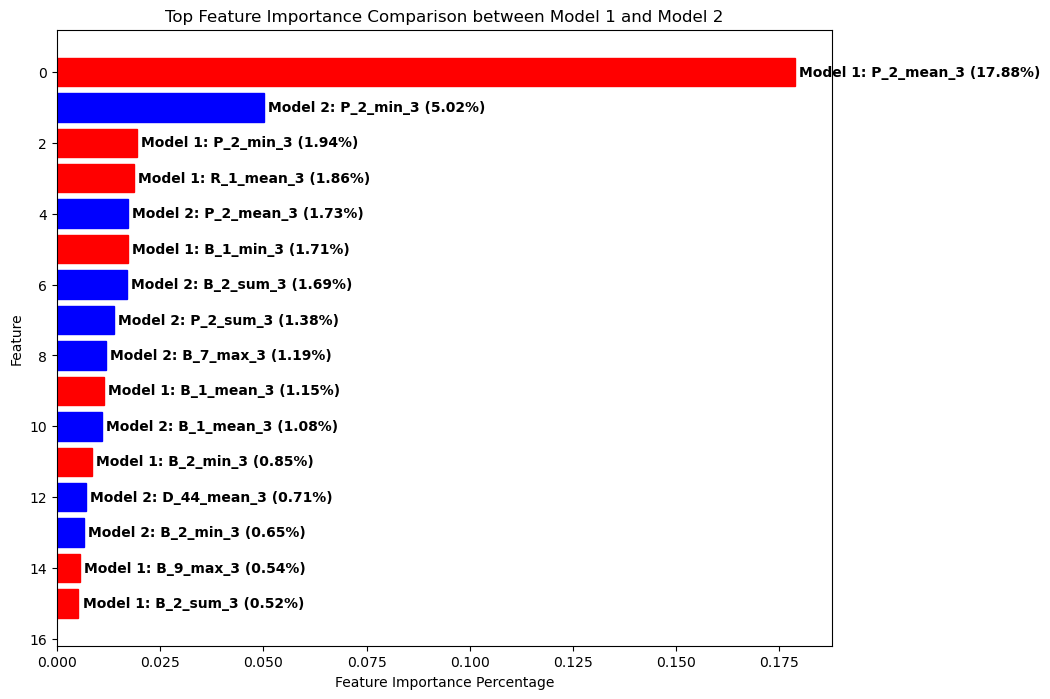

In [34]:
import pandas as pd
import matplotlib.pyplot as plt


# Sort the combined DataFrame by importance values in descending order
feature_importance_concat_df.sort_values(by='Importance', ascending=False, inplace=True)

# Filter the top features
top_features = feature_importance_concat_df.head(60)

# Plotting
plt.figure(figsize=(10, 8))

# Plot horizontal bars
bars = plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')

# Add labels for model name and percentage
for i, bar in enumerate(bars):
    feature = top_features.iloc[i]['Feature']
    importance = top_features.iloc[i]['Importance']
    model = top_features.iloc[i]['Model']
    if importance > 0.005:
        if model == 'Model 1':
            bar.set_color('red')
        else:
            bar.set_color('blue')
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, f'{model}: {feature} ({importance:.2%})', va='center', ha='left', fontsize=10, color='black', weight='bold')

# Add labels and title
plt.xlabel('Feature Importance Percentage')
plt.ylabel('Feature')
plt.title('Top Feature Importance Comparison between Model 1 and Model 2')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top

# Show plot
plt.show()



In [46]:
### step 9: When to resume training process
# Load the training data, applying important features calculated by step 8
# Load the training data, applying important features calculated by step 8
X_train = pd.read_csv('data/X_train.csv')
# feature_importance_parameter_model_df = pd.read_csv('output/feature_importance_parameter_model.csv')
X_train = X_train[feature_importance_concat_df['Feature']]
y_train = pd.read_csv('data/y_train.csv')

X_test1 = pd.read_csv('data/X_test1.csv')
X_test1 = X_test1[feature_importance_concat_df['Feature']]
y_test1 = pd.read_csv('data/y_test1.csv')

X_test2 = pd.read_csv('data/X_test2.csv')
X_test2 = X_test2[feature_importance_concat_df['Feature']]
y_test2 = pd.read_csv('data/y_test2.csv')

In [13]:
Grid_Search_Results = pd.DataFrame(columns = ["Number of Trees", "Learning Rate (LR)", 'Subsample', '% Features', 'Weight of Default',"AUC Train", "AUC Test 1", "AUC Test 2"])

In [48]:
Counter = 0
for n_trees in [50, 100, 300]:
    for lr in [0.01, 0.1]:
        for subsample in [0.5, 0.8]:
            for colsample in [0.5, 1.0]:
                for weight in [1, 5, 10]:
                    xgb_instance = xgb.XGBClassifier(n_estimators= n_trees, learning_rate = lr,subsample=subsample, colsample_bytree=colsample, scale_pos_weight=weight)                    
                    model = xgb_instance.fit(X_train, y_train)
                    
                    Grid_Search_Results.loc[Counter,"Number of Trees"] = n_trees
                    Grid_Search_Results.loc[Counter,"Learning Rate (LR)"] = lr
                    Grid_Search_Results.loc[Counter,"Subsample"] = subsample
                    Grid_Search_Results.loc[Counter,"% Features"] = colsample
                    Grid_Search_Results.loc[Counter,"Weight of Default"] = weight
                    
                    Grid_Search_Results.loc[Counter,"AUC Train"] = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
                    Grid_Search_Results.loc[Counter,"AUC Test 1"] = roc_auc_score(y_test1, model.predict_proba(X_test1)[:,1])
                    Grid_Search_Results.loc[Counter,"AUC Test 2"] = roc_auc_score(y_test2, model.predict_proba(X_test2)[:,1])

                    Counter += 1
                    print('complete iteration:', Counter)
print('Grid search completed')
Grid_Search_Results.to_csv("output/Grid_Search_Results.csv")

complete iteration: 1
complete iteration: 2
complete iteration: 3
complete iteration: 4
complete iteration: 5
complete iteration: 6
complete iteration: 7
complete iteration: 8
complete iteration: 9
complete iteration: 10
complete iteration: 11
complete iteration: 12
complete iteration: 13
complete iteration: 14
complete iteration: 15
complete iteration: 16
complete iteration: 17
complete iteration: 18
complete iteration: 19
complete iteration: 20
complete iteration: 21
complete iteration: 22
complete iteration: 23
complete iteration: 24
complete iteration: 25
complete iteration: 26
complete iteration: 27
complete iteration: 28
complete iteration: 29
complete iteration: 30
complete iteration: 31
complete iteration: 32
complete iteration: 33
complete iteration: 34
complete iteration: 35
complete iteration: 36
complete iteration: 37
complete iteration: 38
complete iteration: 39
complete iteration: 40
complete iteration: 41
complete iteration: 42
complete iteration: 43
complete iteration: 

In [73]:
Grid_Search_Results = pd.read_csv('output/Grid_Search_Results.csv')
Grid_Search_Results

,Unnamed: 0,Number of Trees,Learning Rate (LR),Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2
0,0,50,0.01,0.5,0.5,1,0.942934,0.941506,0.938124
1,1,50,0.01,0.5,0.5,5,0.942033,0.940656,0.937163
2,2,50,0.01,0.5,0.5,10,0.941684,0.940328,0.936314
3,3,50,0.01,0.5,1.0,1,0.944099,0.942023,0.938624
4,4,50,0.01,0.5,1.0,5,0.942963,0.941057,0.938003
...,...,...,...,...,...,...,...,...,...
67,67,300,0.10,0.8,0.5,5,0.970592,0.942749,0.940652
68,68,300,0.10,0.8,0.5,10,0.969102,0.942608,0.939753
69,69,300,0.10,0.8,1.0,1,0.974293,0.942403,0.939500
70,70,300,0.10,0.8,1.0,5,0.972858,0.942074,0.939852


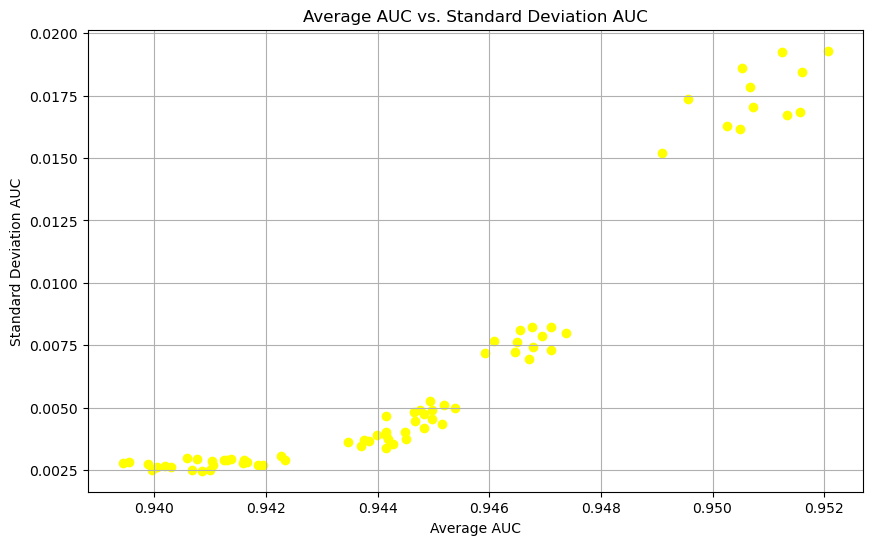

In [76]:
## Calculate average and standard deviation of AUC across three samples (train and two tests)
Grid_Search_Results['Average AUC'] = Grid_Search_Results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].mean(axis=1)
Grid_Search_Results['Standard Deviation AUC'] = Grid_Search_Results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].std(axis=1)

## Create a scatter plot of average AUC and standard deviation AUC
plt.figure(figsize=(10, 6))
plt.scatter(Grid_Search_Results['Average AUC'], Grid_Search_Results['Standard Deviation AUC'], color='yellow')
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation AUC')
plt.title('Average AUC vs. Standard Deviation AUC')
plt.grid(True)
plt.show()








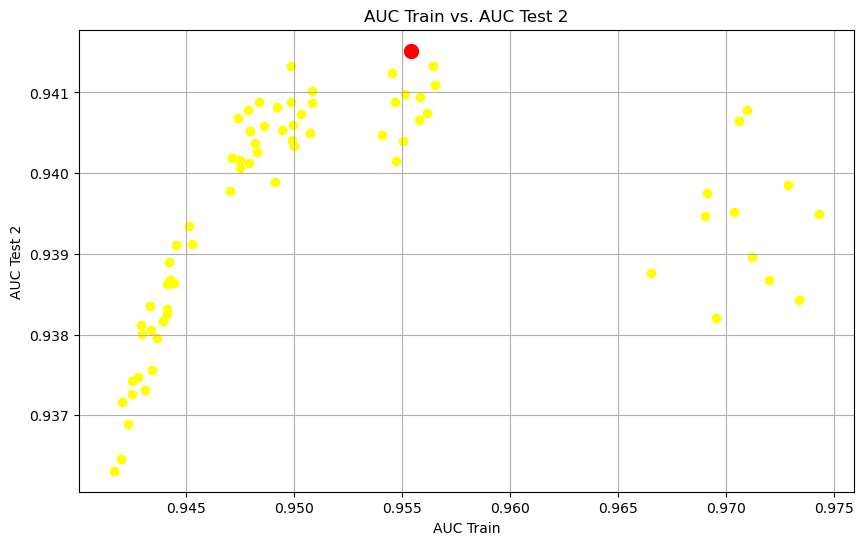

In [81]:
# X-Axis is AUC of train sample and Y-Axis is AUC of Test 2 sample
plt.figure(figsize=(10, 6))
plt.scatter(Grid_Search_Results['AUC Train'], Grid_Search_Results['AUC Test 2'], color='yellow')

# Find
highest_index = Grid_Search_Results['AUC Test 2'].idxmax()
plt.scatter(Grid_Search_Results.loc[highest_index, 'AUC Train'], Grid_Search_Results.loc[highest_index, 'AUC Test 2'], color='red', s=100, label='Highest AUC Test 2')
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('AUC Train vs. AUC Test 2')
plt.grid(True)
plt.show()

In [82]:
Grid_Search_Results

,Unnamed: 0,Number of Trees,Learning Rate (LR),Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,Average AUC,Standard Deviation AUC
0,0,50,0.01,0.5,0.5,1,0.942934,0.941506,0.938124,0.940855,0.002470
1,1,50,0.01,0.5,0.5,5,0.942033,0.940656,0.937163,0.939951,0.002511
2,2,50,0.01,0.5,0.5,10,0.941684,0.940328,0.936314,0.939442,0.002793
3,3,50,0.01,0.5,1.0,1,0.944099,0.942023,0.938624,0.941582,0.002764
4,4,50,0.01,0.5,1.0,5,0.942963,0.941057,0.938003,0.940675,0.002502
...,...,...,...,...,...,...,...,...,...,...,...
67,67,300,0.10,0.8,0.5,5,0.970592,0.942749,0.940652,0.951331,0.016713
68,68,300,0.10,0.8,0.5,10,0.969102,0.942608,0.939753,0.950488,0.016184
69,69,300,0.10,0.8,1.0,1,0.974293,0.942403,0.939500,0.952065,0.019304
70,70,300,0.10,0.8,1.0,5,0.972858,0.942074,0.939852,0.951595,0.018448


In [ ]:
# Find the best parameters
best_parameters = Grid_Search_Results.loc[Grid_Search_Results['Average AUC'].idxmax()]
best_model = xgb.XGBClassifier(
    n_estimators=int(best_parameters['Number of Trees']),
    learning_rate=best_parameters['Learning Rate (LR)'],
    subsample=best_parameters['Subsample'],
    colsample_bytree=best_parameters['% Features'],
    scale_pos_weight=best_parameters['Weight of Default']
)

In [71]:
Grid_Search_Results

,Unnamed: 0,Number of Trees,Learning Rate (LR),Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2,AUC Train Mean,AUC Test 1 Mean,AUC Test 2 Mean,AUC Train Std,AUC Test 1 Std,AUC Test 2 Std
0,0,50,0.01,0.5,0.5,1,0.942934,0.941506,0.938124,0.951815,0.942775,0.939539,0.009556,0.001301,0.001356
1,1,50,0.01,0.5,0.5,5,0.942033,0.940656,0.937163,0.951815,0.942775,0.939539,0.009556,0.001301,0.001356
2,2,50,0.01,0.5,0.5,10,0.941684,0.940328,0.936314,0.951815,0.942775,0.939539,0.009556,0.001301,0.001356
3,3,50,0.01,0.5,1.0,1,0.944099,0.942023,0.938624,0.951815,0.942775,0.939539,0.009556,0.001301,0.001356
4,4,50,0.01,0.5,1.0,5,0.942963,0.941057,0.938003,0.951815,0.942775,0.939539,0.009556,0.001301,0.001356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,67,300,0.10,0.8,0.5,5,0.970592,0.942749,0.940652,0.951815,0.942775,0.939539,0.009556,0.001301,0.001356
68,68,300,0.10,0.8,0.5,10,0.969102,0.942608,0.939753,0.951815,0.942775,0.939539,0.009556,0.001301,0.001356
69,69,300,0.10,0.8,1.0,1,0.974293,0.942403,0.939500,0.951815,0.942775,0.939539,0.009556,0.001301,0.001356
70,70,300,0.10,0.8,1.0,5,0.972858,0.942074,0.939852,0.951815,0.942775,0.939539,0.009556,0.001301,0.001356


In [50]:
print(best_parameters)
best_model

{'Number of Trees': 300, 'Learning Rate (LR)': 0.1, 'Subsample': 0.8, '% Features': 1.0, 'Weight of Default': 1}


69

In [53]:
# Train the best model
best_xgb_model = xgb.XGBClassifier(
    n_estimators=int(best_parameters['Number of Trees']),
    learning_rate=best_parameters['Learning Rate (LR)'],
    subsample=best_parameters['Subsample'],
    colsample_bytree=best_parameters['% Features'],
    scale_pos_weight=best_parameters['Weight of Default']
)
best_xgb_model.fit(X_train, y_train)

# Save the best model
best_xgb_model.save_model('best_xgb_model.json')

In [74]:
# Load the model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('output/best_xgb_model.json')

In [54]:
# step 10: Neural Network
# Data Preprocessing
outliers = pd.DataFrame(columns = ['Feature', 'p1', 'p99'])

counter = 1
for col in X_train.columns:
    p1 = X_train[col].quantile(0.01)
    p99 = X_train[col].quantile(0.99)
    outliers.loc[counter] = [col, p1, p99]
    counter += 1
    print('complete iteration:', counter)
print('----Calculation Complete----')
outliers.to_csv('output/outliers.csv', index=False)



complete iteration: 2
complete iteration: 3
complete iteration: 4
complete iteration: 5
complete iteration: 6
complete iteration: 7
complete iteration: 8
complete iteration: 9
complete iteration: 10
complete iteration: 11
complete iteration: 12
complete iteration: 13
complete iteration: 14
complete iteration: 15
----Calculation Complete----


In [55]:
# replace outliers with p1 and p99
X_train = X_train.clip(lower = X_train.quantile(0.01), upper = X_train.quantile(0.99), axis = 1)
X_test1 = X_test1.clip(lower = X_train.quantile(0.01), upper = X_train.quantile(0.99), axis = 1)
X_test2 = X_test2.clip(lower = X_train.quantile(0.01), upper = X_train.quantile(0.99), axis = 1)

In [56]:
# feature scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test1_scaled = pd.DataFrame(scaler.transform(X_test1), columns = X_train.columns)
X_test2_scaled = pd.DataFrame(scaler.transform(X_test2), columns = X_train.columns)


In [57]:
# fill missing values with 0
print('Number of missing values in X_train:', X_train_scaled.isnull().sum().sum())
print('Number of missing values in X_test1:', X_test1_scaled.isnull().sum().sum())
print('Number of missing values in X_test2:', X_test2_scaled.isnull().sum().sum())


Number of missing values in X_train: 55909
Number of missing values in X_test1: 11997
Number of missing values in X_test2: 11979


In [58]:
X_train_scaled.fillna(0, inplace=True)
X_test1_scaled.fillna(0, inplace=True)
X_test2_scaled.fillna(0, inplace=True)

In [59]:
# Check the number of missing values again
print('Number of missing values in X_train:', X_train_scaled.isnull().sum().sum())
print('Number of missing values in X_test1:', X_test1_scaled.isnull().sum().sum())
print('Number of missing values in X_test2:', X_test2_scaled.isnull().sum().sum())

Number of missing values in X_train: 0
Number of missing values in X_test1: 0
Number of missing values in X_test2: 0


In [60]:
X_train_scaled

,P_2_min_3,B_11_min_3,B_2_sum_6,P_2_sum_3,D_44_max_12,D_42_max_6,B_1_max_3,P_2_mean_3,R_1_mean_3,B_1_min_3,B_1_mean_3,B_2_min_3,B_9_max_3,B_2_sum_3
0,-0.650809,-0.154200,-1.406933,-0.051839,-0.651831,0.000000,-0.225414,-0.100086,-0.410863,-0.070301,-0.150938,-1.172024,0.923663,-1.397350
1,-0.655672,1.198938,-0.463044,-0.678755,2.274824,0.000000,1.199052,-0.746734,-0.406592,1.321831,1.238736,-1.214813,-0.767820,-1.346659
2,-1.643313,0.374681,-1.468284,-1.620546,4.212030,0.382075,0.290951,-1.718166,1.492090,0.491907,0.393126,-1.216151,1.558677,-1.416897
3,0.124724,-0.502704,0.613785,0.103288,-0.656168,0.000000,-0.625817,0.059923,-0.422977,-0.552944,-0.595677,0.685589,-0.768932,0.584513
4,-0.178081,-0.509591,0.778785,-0.216368,-0.652651,0.000000,-0.635297,-0.269794,-0.428528,-0.563172,-0.606298,0.676677,-0.767048,0.904216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64243,0.880030,-0.498854,0.616683,1.018272,-0.654837,0.000000,-0.629035,1.003705,-0.421076,-0.561018,-0.602401,0.681646,-0.772839,0.585047
64244,0.540434,-0.181660,-1.442948,0.527134,0.319988,0.000000,-0.228447,0.497109,-0.426669,-0.065095,-0.153812,-1.184948,1.243813,-1.412472
64245,0.000000,-0.499780,0.679887,-2.365119,0.000000,0.000000,-0.531187,0.000000,-0.424694,-0.485862,-0.520850,-1.265988,-0.772327,0.213664
64246,-0.165413,-0.510634,1.125710,-0.145014,-0.651150,-0.789057,-0.628512,-0.196194,-0.418504,-0.539091,-0.592630,1.136758,-0.536272,1.077220


In [61]:
X_train_scaled.to_csv('data/X_train_scaled.csv', index=False)
X_test1_scaled.to_csv('data/X_test1_scaled.csv', index=False)
X_test2_scaled.to_csv('data/X_test2_scaled.csv', index=False)

In [62]:
# load data for nn
X_train_scaled = pd.read_csv('data/X_train_scaled.csv')
X_test1_scaled = pd.read_csv('data/X_test1_scaled.csv')
X_test2_scaled = pd.read_csv('data/X_test2_scaled.csv')

y_train = pd.read_csv('data/y_train.csv')
y_test1 = pd.read_csv('data/y_test1.csv')
y_test2 = pd.read_csv('data/y_test2.csv')

In [63]:
# build neural network
nn_grid_search_result = pd.DataFrame(columns = ["#HL", "#Nodes", "ActivationFunction", "Dropout", "BatchSize", "AUC_Train", "AUC_Test1", "AUC_Test2"])

Counter = 0
for hl in [2,4]:
    for nodes in [4,6]:
        for activate_function in ["relu", "tanh"]:
            for dropout in [0, 0.5]:
                for batch_size in [100, 10000]:
                    model = Sequential()
                    model.add(Dense(nodes, input_dim=X_train_scaled.shape[1], activation=activate_function))
                    model.add(Dropout(dropout))
                    for i in range(hl - 1):
                        model.add(Dense(nodes, activation=activate_function))
                        model.add(Dropout(dropout))
                    model.add(Dense(1, activation='sigmoid'))
                    model.compile(optimizer=Adam(), loss=BinaryCrossentropy())
                    model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=20)
                    
                    nn_grid_search_result.loc[Counter, "#HL"] = hl
                    nn_grid_search_result.loc[Counter, "#Nodes"] = nodes
                    nn_grid_search_result.loc[Counter, "ActivationFunction"] = activate_function
                    nn_grid_search_result.loc[Counter, "Dropout"] = dropout
                    nn_grid_search_result.loc[Counter, "BatchSize"] = batch_size
                    nn_grid_search_result.loc[Counter, "AUC_Train"] = roc_auc_score(y_train, model.predict(X_train_scaled))
                    nn_grid_search_result.loc[Counter, "AUC_Test1"] = roc_auc_score(y_test1, model.predict(X_test1_scaled))
                    nn_grid_search_result.loc[Counter, "AUC_Test2"] = roc_auc_score(y_test2, model.predict(X_test2_scaled))
                    
                    Counter += 1

print('Grid search completed')
nn_grid_search_result.to_csv('output/nn_grid_search_result.csv')
                    
                    

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 429us/step - loss: 0.6801
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 0.4743
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.3956
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 0.3524
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.3276
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.3116
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.3033
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.2999
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 0.2924
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 0.2877
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.2865
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 0.2829
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.2787
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 0.2762
Epoch 15/20
643/643 ━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7078  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6799 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 0.6517
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6245 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6034 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5837 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5656 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5467 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5280 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5076 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4882 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4676 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.4500
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4320 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4154 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - loss: 0.6078
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.4788
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 0.4526
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.4502
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.4489
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 0.4474
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.4485
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 0.4503
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.4486
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.4461
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.4477
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.4423
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.4475
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 0.4475
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7674  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7476 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7221 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7029 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6892 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6735 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6597 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6428 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6325 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6169 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6041 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6021 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5897 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5799 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5721 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - loss: 0.5600
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 0.3004
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 0.2898
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 0.2839
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 0.2847
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 0.2803
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2786
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2780
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2744
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2839
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2758
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 0.2742
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.2751
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.2761
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8163  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7813 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.7462
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.7172
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6879 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6646 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.6391
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6195 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.6032
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.5846
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 0.5670
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5569 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5434  
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5314 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5210 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step - loss: 0.5577
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.3848
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 0.3754
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.3656
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.3607
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 0.3601
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.3569
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.3557
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 0.3543
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.3592
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 0.3546
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 0.3529
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 0.3553
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.3544
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7030  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6789 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6585 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6423 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6276 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6158 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6024 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5975 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5888 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5801 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5701 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5647 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5599 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5559 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5472 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - loss: 0.4901
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 0.2869
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 0.2724
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.2749
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 0.2714
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 0.2752
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.2719
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.2734
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.2692
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 0.2731
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.2721
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 0.2691
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 0.2742
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.2728
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6903  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6770 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6606 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6462 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6303 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6150 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6004 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5846 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5693 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5535 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5366 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5158 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4948 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4708 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4525 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - loss: 0.6878
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.4372
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.4020
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.3864
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 0.3779
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 0.3764
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 0.3767
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.3767
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.3725
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 0.3719
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.3700
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 0.3735
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.3716
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 0.3708
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0414  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9653 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9006 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8762 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8175 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7862 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7559 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7229 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6905 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6639 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6389 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6222 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6041 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5815 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5738 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - loss: 0.4806
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 0.2903
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 0.2804
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 0.2794
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 0.2807
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 0.2783
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 0.2751
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.2776
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.2761
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 0.2764
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 0.2773
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.2721
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 0.2751
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 0.2695
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8841  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8161 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7554 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7032 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6577 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6194 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5839 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5536 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5254 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5006 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4791 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4607 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4446 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4303 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4170 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step - loss: 0.5922
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.3711
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 0.3496
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 0.3405
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 0.3365
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 0.3365
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.3326
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.3347
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 0.3361
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 0.3335
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 0.3316
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 0.3275
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 0.3278
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 0.3331
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8438  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8054 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7671 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7332 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6990 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6750 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6517 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6322 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6142 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5973 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5824 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5672 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5553 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5457 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5365 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - loss: 0.4363
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - loss: 0.2815
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.2818
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 0.2773
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 0.2738
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 0.2757
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 0.2746
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 0.2714
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.2712
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.2699
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 0.2727
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 0.2743
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.2760
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.2745
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6952  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6886 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6821 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6764 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6697 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6624 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6521 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6377 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6164 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5935 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5715 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5480 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5257 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5063 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4874 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - loss: 0.9752
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 0.5830
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.5566
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.5275
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.5150
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.5099
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.5067
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.5009
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 0.4996
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 0.5027
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 0.4980
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.4990
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.4991
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - loss: 0.4996
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8164
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7951 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7813 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7554 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7432 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7209 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7132 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6997 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6926 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6805 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6714 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6681 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6577 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6519 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6491 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - loss: 0.4668
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 0.2940
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 0.2889
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 0.2800
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.2787
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.2786
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.2772
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 0.2778
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 0.2772
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.2738
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.2725
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 0.2749
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 0.2737
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 0.2751
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6928
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6567 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6240 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5952 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5699 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5484 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5281 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5104 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4930
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4756
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4598
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4450
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4324 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4175 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4051 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 622us/step - loss: 0.6524
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 0.4799
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 0.4409
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.4211
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 0.4092
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.4056
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3980
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4040
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3943
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.3966
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 0.3985
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 0.3956
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 0.3996
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 0.3905
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 52

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7448  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7253 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7062 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6880 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6762 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6633 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6526 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6402 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6300 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6224 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6137 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6064 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6015 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5948 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5867 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - loss: 0.4429
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.2798
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.2800
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.2761
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.2729
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.2728
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.2736
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 0.2756
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 0.2733
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 0.2715
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.2721
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 0.2690
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.2720
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.2729
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7178  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6960 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6789 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6633 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6447 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6276 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6086 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5885 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5670 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5440 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5219 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4992 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4776 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4576 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4376 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - loss: 0.6479
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.5262
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 0.5009
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.4762
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.4677
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.4529
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 0.4447
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.4442
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.4426
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 0.4414
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.4378
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.4409
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.4445
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 0.4398
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7292  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7177 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7032 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6962 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6906 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6862 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6824 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6772 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6749 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6704 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6661 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6634 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6605 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6575 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6541 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 0.4869
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.2944
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.2804
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 0.2812
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 0.2802
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.2796
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.2758
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 0.2779
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 0.2778
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 0.2750
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 0.2747
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.2756
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 0.2726
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 0.2768
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6614  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6186 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5792 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5428 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5088 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4770 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4488 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4245 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4010 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3831 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3683 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3561 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3462 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3363 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3295 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 ━━━━━━━━━━━━━━━━━━━━ 37s 505us/step - loss: 0.5926
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.4105
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.3864
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.3717
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.3654
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 0.3627
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 0.3563
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.3559
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.3562
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.3570
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.3520
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.3538
Epoch 13/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 0.3583
Epoch 14/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 0.3543
Epoch 15/20
643/643 ━━━━━━━━━━━━━━━━━━━

/Users/itoshi/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7489  
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7221 
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6969 
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6735 
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6570 
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6429 
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6297 
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6225 
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6115 
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6026 
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5936 
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5849 
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5785 
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5688 
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5603 
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

In [64]:
nn_grid_search_result = pd.read_csv('output/nn_grid_search_result.csv', index_col=0)
nn_grid_search_result

,#HL,#Nodes,ActivationFunction,Dropout,BatchSize,AUC_Train,AUC_Test1,AUC_Test2
0,2,4,relu,0.0,100,0.937706,0.940149,0.936429
1,2,4,relu,0.0,10000,0.927040,0.930282,0.925276
2,2,4,relu,0.5,100,0.936715,0.939418,0.935537
3,2,4,relu,0.5,10000,0.895927,0.901307,0.895857
4,2,4,tanh,0.0,100,0.936607,0.939496,0.936229
5,2,4,tanh,0.0,10000,0.823929,0.832054,0.819274
6,2,4,tanh,0.5,100,0.936339,0.938840,0.935383
7,2,4,tanh,0.5,10000,0.913145,0.917832,0.912122
8,2,6,relu,0.0,100,0.938592,0.940596,0.937435
9,2,6,relu,0.0,10000,0.931316,0.934847,0.930024
